ML Course, Bogotá, Colombia  (&copy; Josh Bloom; June 2019)

In [48]:
%run ../talktools.py

<Figure size 432x288 with 0 Axes>

## Autoencoders

A form of non-parametric representation learning with neutral nets, where the architecture of the network is used to reduce the dimensionality of the data. We will see forms of parametric dimensionality reduction in Lecture 7. 

As the name suggests, autoencoders uses the data itself to learn the best way to represent it in a compact way--it's a form of semantic compression. This is a family of self- (or un-) supervised modeling.

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png">
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In practice, we take an input X (which may be a 1-d vector, 2-d image, ...) and try to squeeze it down to a smaller number of values in the "bottleneck" layer and then uncompress back to it's original shape and form. The loss function that we construct will be the way in which the network learns on each backprop through the data.

Let's look at a autoencoder which uses convnets to restruct the fashion dataset.

### Notes:

Another way to think about autoencoders is as a powerful featurization method/algorithm, because you compress the data into a few numbers/features, in the bottleneck layer.

In [2]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, \
                                                            Activation, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
import tensorflow as tf

# Print keras version
print(tensorflow.keras.__version__)

2.2.4-tf


In [5]:
from tensorflow.keras.utils import to_categorical

fashion_mnist = tf.keras.datasets.fashion_mnist

nb_classes = 10
batch_size = 128
bottleneck_size = 64

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape
input_img = Input(shape = (28, 28, 1))

In [3]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4,4,8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Repeat values, making images bigger somehow
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# add with tf.device('/gpu:0'): if on GPU
autoencoder = Model(input_img, decoded)

In [4]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584   

In [8]:
import tensorflow 

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/colombia_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_loss', 
        save_best_only=True, 
        mode='min',
        verbose=1)

tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(logdir, 
                                                              histogram_freq=0, 
                                                              write_graph=True, 
                                                              write_grads=False, 
                                                              write_images=False, 
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train, 
                                                          batch_size=batch_size,epochs=10,
                                                          verbose=1, shuffle=False, 
                                                          validation_data=(x_test, x_test),
                                                          callbacks=[tensorboard_callback, model_check])

Training ... nn_results/colombia_autoencoder_nn_2019-06-06T18:37.h5
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59904/60000 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 00001: val_loss improved from inf to 0.02030, saving model to nn_results/colombia_autoencoder_nn_2019-06-06T18:37.h5
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.0226 - val_loss: 0.0203
Epoch 2/10
59904/60000 [============================>.] - ETA: 0s - loss: 0.0197
Epoch 00002: val_loss improved from 0.02030 to 0.01848, saving model to nn_results/colombia_autoencoder_nn_2019-06-06T18:37.h5
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.0197 - val_loss: 0.0185
Epoch 3/10
59904/60000 [============================>.] - ETA: 0s - loss: 0.0183
Epoch 00003: val_loss improved from 0.01848 to 0.01733, saving model to nn_results/colombia_autoencoder_nn_2019-06-06T18:37.h5
60000/60000 [==============================] - 66s 1ms/sample - loss: 

KeyboardInterrupt: 

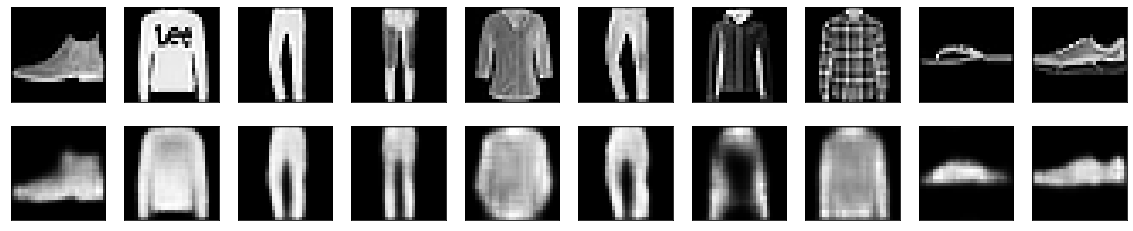

In [9]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

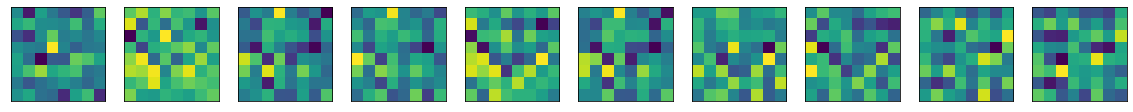

In [10]:
encoder = Model(input_img, bottleneck)
encoded_imgs = encoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(8, 8).T, cmap="viridis")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Think of the above as the (encoded) high-level concept of each image. Can you see the similarities across classes?

### Notes:

*  We do see the similarities, check for example last two bottleneck images (shoes), or 3rd and 4th (pants).
* If I run this in a different machine or different instance I don't get the exact same results, because of stochasticity. So this means that these representations are not really universal.

What can we do with this network?

  - **Remote compression** - if we have the encoder on our phone (or some other device) we can encode images there and send the bottleneck elsewhere (more than a factor of 10 compression with this network). We can later decode the data elsewhere to get back a fair representation of the original data. This is a great bandwidth saver! It also creates an interesting level of anonymity (if the bottleneck data is intercepted, no one without the decoder could figure out what the original images looked like).
   
  - **Classification** - we just built 64 features without using, for example, our knowledge of computer vision. And we avoiding coding 64 separate features.
  
  - **Clustering** - this is a non-parametric way of finding low-dimensional embedding of our data. We'll see more of this in Lecture 7.

# Breakout

a) Using the autoencoder model above, create a random forest model to predict the classes of the images using the 64-parameter bottleneck layer. What accuracy do you get? How does it compare with the accuracy we got on the `convnet` model before?

b) Experiment with trying a different sized layer (e.g., size 4, 16, 32) and repeat step a) above. Do you see any trends with bottleneck size?

## Solution to breakout - hopefully

In [40]:
Xtr = encoded_imgs[:7000]
Ytr = y_train[:7000]
Xtest = encoded_imgs[7000:]
Ytest = y_train[7000:]

In [41]:
Xtr.shape

(7000, 64)

In [42]:
Ytr.shape

(7000,)

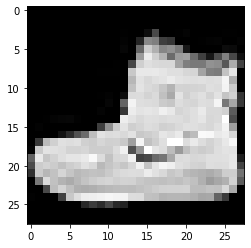

In [20]:
plt.imshow(x_train[0].reshape(28,28))

In [22]:
x_train.shape

(60000, 28, 28, 1)

In [43]:
# Create a classifier: 
from sklearn.ensemble import RandomForestClassifier

# instantiate classifier object
classifier = RandomForestClassifier(n_estimators=20)

# fit the classification model on training set
classifier.fit(Xtr, Ytr)

# make predictions for testing set
pred_rf = classifier.predict(Xtest) 

print("True Class / Predicted class")
print(np.vstack((Ytest[0:20],pred_rf[0:20])))

True Class / Predicted class
[[9 0 5 8 1 0 8 6 7 5 0 4 0 9 0 6 6 4 1 6]
 [9 3 4 7 5 1 1 4 3 3 9 0 2 8 2 3 9 1 7 2]]


In [33]:
# compute zero-one loss / score & confusion matrix
from sklearn import metrics

rf_01 = metrics.zero_one_loss(Ytest, pred_rf) # zero-one loss
rf_01_score = metrics.accuracy_score(Ytest, pred_rf) # zero-one score
rf_confmat = metrics.confusion_matrix(Ytest, pred_rf) # conf mat

print("Zero-One Loss: " + str(rf_01))
print("Zero-One Score: " + str(rf_01_score))
print("Confusion Matrix:")
print("[i, j] is the # of objects truly in group i but predicted to be in group j")
print(rf_confmat)

ValueError: Found input variables with inconsistent numbers of samples: [55000, 5000]

## Denoising Autoencoder

Another application of autoencoders is to construct a model which takes low signal-to-noise data and produces high signal-to-noise versions.  For example, https://thenextweb.com/insider/2017/02/08/google-figured-out-a-way-to-zoom-and-enhance-photos-just-like-in-the-movies/

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('I_8ZH1Ggjk0?t=27')

Here the model is very similar as before except that we feed in a corrupted/low SNR version in the input and compare the output against a higher fidelity version.

In [44]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

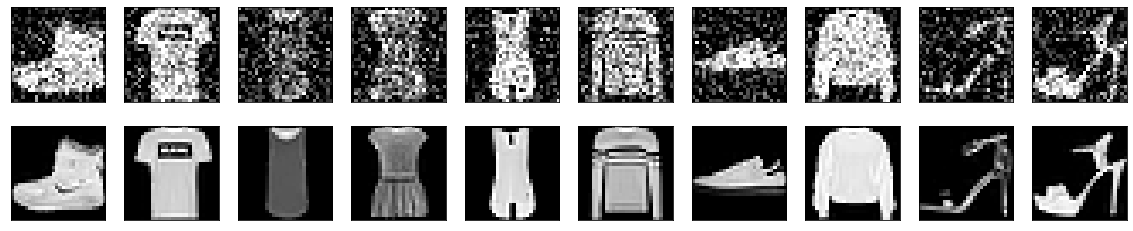

In [45]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display high SNR version
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [46]:
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/colombia_denoise_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_loss', 
        save_best_only=True, 
        mode='min',
        verbose=1)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train_noisy, x_train, 
                                                          batch_size=batch_size,epochs=25,
                                                          verbose=1, shuffle=True, 
                                                          validation_data=(x_test_noisy, x_test),
                                                          callbacks=[tensorboard_callback, model_check])

Training ... nn_results/colombia_denoise_autoencoder_nn_2019-06-06T19:21.h5
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
59904/60000 [============================>.] - ETA: 0s - loss: 0.0190
Epoch 00001: val_loss improved from inf to 0.01868, saving model to nn_results/colombia_denoise_autoencoder_nn_2019-06-06T19:21.h5
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.0190 - val_loss: 0.0187
Epoch 2/25
59904/60000 [============================>.] - ETA: 0s - loss: 0.0181
Epoch 00002: val_loss improved from 0.01868 to 0.01767, saving model to nn_results/colombia_denoise_autoencoder_nn_2019-06-06T19:21.h5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.0181 - val_loss: 0.0177
Epoch 3/25
59904/60000 [============================>.] - ETA: 0s - loss: 0.0177
Epoch 00003: val_loss did not improve from 0.01767
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.0177 - val_loss: 0.0196
Epoch 4/25
59904/60000 [==

KeyboardInterrupt: 

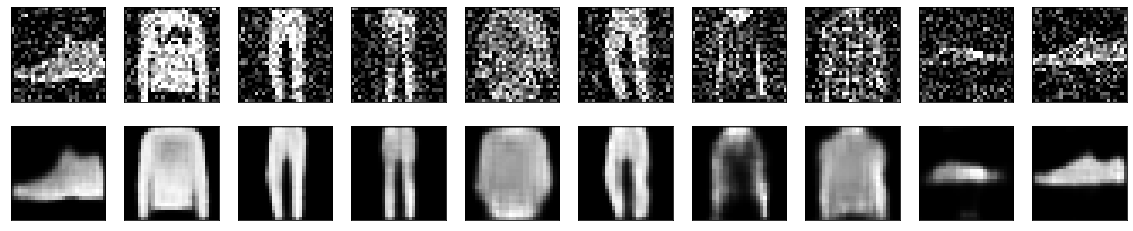

In [47]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational Autoencoder

> A VAE "is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model". -- https://blog.keras.io/building-autoencoders-in-keras.html

<img src="https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png">

> First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + $\exp$(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

Here, the loss includes the standard loss (e.g., MSE) for the image reconstruction and a measure of the difference between the distribution of the original data mapped to latent space and the random sampling in latent space. This K-L divergence is a form of information gain, a non-symmetric measure of the difference between two probability distributions.

In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda

latent_dim = 2
input_img = Input(shape = (28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional


# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 16)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [6]:
models = (encoder, decoder)
data = (x_test, y_test)

In [7]:
from tensorflow.keras.losses import mse, binary_crossentropy
image_size = x_train.shape[1]

# VAE loss = mse + kl_loss
reconstruction_loss = mse(K.flatten(input_img), K.flatten(outputs))

reconstruction_loss *= image_size * image_size

# this is the K-L divergence loss (information gain)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

W0606 14:36:13.127015 140478083630912 training_utils.py:1238] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 4100        input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    2865        encoder[1][2]                    
__________________________________________________________________________________________________
tf_op_layer_Reshape_2 (TensorFl [(None,)]            0           decoder[1][0]                    
________________________________________________________________________________________________

In [9]:
FIT=True

if FIT:
    vae.fit(x_train,
          epochs=50,
          batch_size=batch_size,
          validation_data=(x_test, None))
    vae.save_weights('nn_results/colombia_vae_cnn_fashion_70.h5')
else:
    from keras.models import load_model
    import tensorflow as tf
    
    vae = load_model("nn_results/colombia_vae_cnn_fashion_70.h5")


Train on 60000 samples, validate on 10000 samples
Epoch 1/50


InvalidArgumentError:  You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,28,28,1]
	 [[node input_2 (defined at <ipython-input-9-22f410c8ca71>:7) ]] [Op:__inference_keras_scratch_graph_3143]

Function call stack:
keras_scratch_graph


In [10]:
!ls nn_results/*

nn_results/colombia_autoencoder_nn_2019-06-06T18:37.h5
nn_results/colombia_denoise_autoencoder_nn_2019-06-06T19:21.h5
nn_results/colombia_vae_cnn_fashion_70.h5

nn_results/20190606-133155:
train

nn_results/20190606-133711:
train  validation


In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

lookup = {0: "T-shirt/top",
          1: "Trouser",
          2: "Pullover",
          3: "Dress",
          4: "Coat",
          5: "Sandal",
          6: "Shirt",
          7: "Sneaker",
          8: "Bag",
          9: "Ankle boot"}

cmap = plt.cm.get_cmap('coolwarm', 10)

plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[0][:,1], x_test_encoded[0][:,0], c=y_test,cmap=cmap, s=4)
cbar = plt.colorbar(ticks =np.arange(10), label='clothes type')
cbar.ax.set_yticklabels([lookup[i] for i in range(10)])
plt.show()

Each of these colored clusters is a type of clothing. Close clusters are clothes that are structurally similar (i.e. clothes that share information in the latent space).

Since VAEs are generative models, we can also use it to generate new clothes. Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding piece of clothes for each of these points. This gives us a visualization of the latent manifold that "generates" new clothes.

In [ ]:
# display a 2D manifold of the clother
n = 15  # figure with 15x15 clothes
im_size = 28
figure = np.zeros((im_size * n,im_size * n))
# we will sample n points within [-5, 5] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)

epsilon_std = 1.0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = decoder.predict(z_sample)
        cloth = x_decoded[0].reshape(im_size, im_size)
        figure[i * im_size: (i + 1) * im_size,
               j * im_size: (j + 1) * im_size] = cloth

fig, ax = plt.subplots(figsize=(15, 15))
        
ax.imshow(figure, cmap="viridis")
ax.grid(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()